## Sequential analysis for ratio metrics via linearization
Ratio metrics (e.g., revenue / sessions) are common but statistically tricky:

- The ratio-of-means and mean-of-ratios differ
- Instability can arise from small or zero denominators

In v1 we use a linearization approach (delta-method style), then apply the same sequential pipeline as for mean metrics.

We demonstrate:

- Linearization recap
- Sequential monitoring on linearized signal
- Failure mode: denominator zeros / near-zeros

Outputs:

- Look table for the linearized metric
- z-trajectory with sequential boundary (group sequential or CS)
- Practical guardrails

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tecore.sequential.schema import (
    SequentialSpec,
    LookSchedule,
    SequentialConfig,
    SequentialMode,
    SpendingFunction,
    EffectDirection,
)
from tecore.sequential.preprocess import build_look_table_mean
from tecore.sequential.group_sequential import run_group_sequential
from tecore.sequential.confidence_sequences import run_confidence_sequence
from tecore.sequential.ratio import linearize_ratio
from tecore.sequential.simulate import SequentialSimConfig, simulate_ab_stream

plt.rcParams["figure.figsize"] = (9, 5)
plt.rcParams["axes.grid"] = True

## 1) Simulate a ratio stream and linearize

In [3]:
N = 20000
looks = [2000, 4000, 6000, 8000, 12000, 16000, 20000]
alpha = 0.05

# ratio=True => generate num/den columns
df = simulate_ab_stream(SequentialSimConfig(n=N, effect=0.03, noise_sd=1.0, heavy_tail=False, drift=False, seed=41, ratio=True))

print(df.head())
print("den zeros share:", float((df["den"] <= 0).mean()))

df_lin, baseline = linearize_ratio(
    df,
    num_col="num",
    den_col="den",
    group_col="group",
    control_label="control",
    baseline_mode="first_look",
    first_look_n=looks[0],
)

print("baseline_ratio(first_look, control)=", baseline)
print(df_lin[["group", "num", "den", "y_lin"]].head())

   unit_id    group       num  den  timestamp
0        0     test  6.530237  7.0          0
1        1     test  6.312827  7.0          1
2        2  control  5.260174  5.0          2
3        3     test  2.141613  4.0          3
4        4     test  5.081781  2.0          4
den zeros share: 0.0
baseline_ratio(first_look, control)= 0.9973360639054847
     group       num  den     y_lin
0     test  6.530237  7.0 -0.451115
1     test  6.312827  7.0 -0.668525
2  control  5.260174  5.0  0.273494
3     test  2.141613  4.0 -1.847731
4     test  5.081781  2.0  3.087109


## 2) Run sequential monitoring on the linearized metric
We show two modes:

- Group sequential (OBF)
- Confidence sequence (anytime-valid)

In [4]:
spec = SequentialSpec(group_col="group", control_label="control", test_label="test", y_col="y_lin", timestamp_col="timestamp")
schedule = LookSchedule(looks=looks)

# Group sequential (OBF)
cfg_gs = SequentialConfig(
    mode=SequentialMode.GROUP_SEQUENTIAL,
    alpha=alpha,
    two_sided=True,
    spending=SpendingFunction.OBRIEN_FLEMING,
    effect_direction=EffectDirection.TWO_SIDED,
    min_n_per_group=200,
    var_floor=1e-12,
    seed=41,
)
lt_gs, warn_gs = build_look_table_mean(df_lin, spec, schedule, cfg_gs)
res_gs = run_group_sequential(lt_gs, cfg_gs)

# Confidence sequence
cfg_cs = SequentialConfig(
    mode=SequentialMode.CONFIDENCE_SEQUENCE,
    alpha=alpha,
    two_sided=True,
    effect_direction=EffectDirection.TWO_SIDED,
    min_n_per_group=200,
    var_floor=1e-12,
    seed=41,
)
lt_cs, warn_cs = build_look_table_mean(df_lin, spec, schedule, cfg_cs)
res_cs = run_confidence_sequence(lt_cs, cfg_cs)

print("GS decision:", res_gs.decision, "stopped=", res_gs.stopped, "stop_look=", res_gs.stop_look)
print("CS decision:", res_cs.decision, "stopped=", res_cs.stopped, "stop_look=", res_cs.stop_look)

display(res_gs.look_table.head())

GS decision: reject stopped= True stop_look= 8000
CS decision: reject stopped= True stop_look= 12000


,n_control,n_test,mean_control,mean_test,var_control,var_test,diff,se,z,info,look_n,t,boundary_z,p_value,crossed
0,964,1036,8.789650e-16,0.101034,0.971058,0.997668,0.101034,0.044388,2.276151,507.531343,2000,0.100741,6.175105,2.283699e-02,False
1,1937,2063,2.805040e-03,0.070422,0.968716,0.992725,0.067617,0.031326,2.158500,1019.039658,4000,0.202272,4.357930,3.088896e-02,False
2,2964,3036,1.447977e-02,0.092405,1.018464,0.993364,0.077925,0.025900,3.008688,1490.743471,6000,0.295902,3.603084,2.623783e-03,False
3,3965,4035,1.200431e-02,0.091480,1.008411,0.994645,0.079476,0.022379,3.551309,1996.675221,8000,0.396325,3.113308,3.833196e-04,True
4,5960,6040,1.439277e-02,0.110318,1.001366,0.995440,0.095926,0.018243,5.258095,3004.605885,12000,0.596392,2.537944,1.455554e-07,True


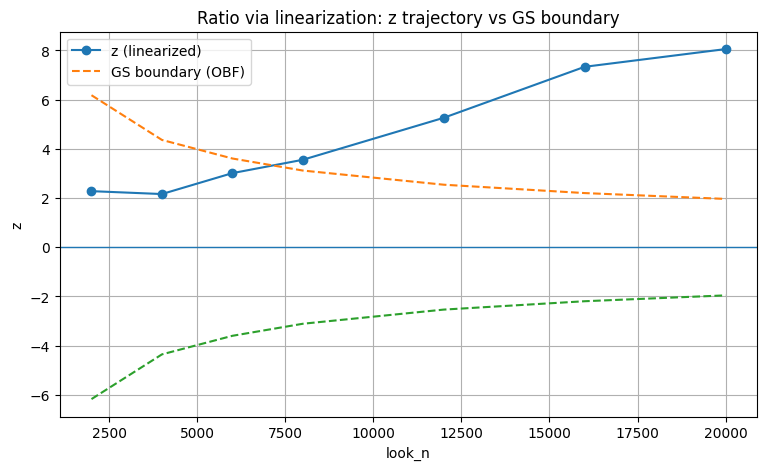

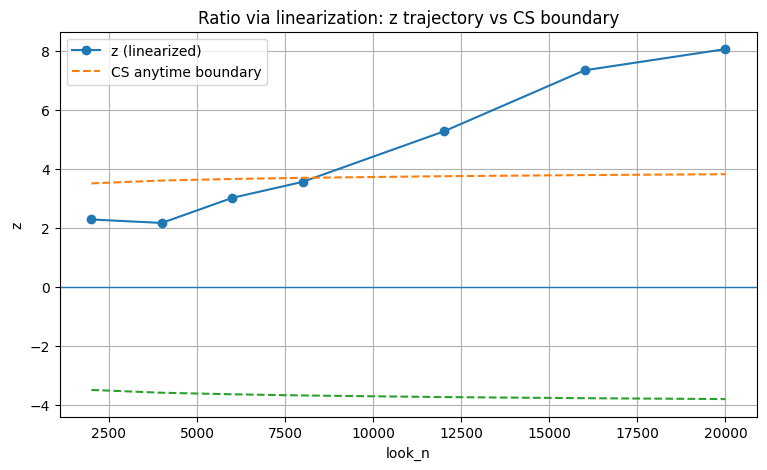

In [5]:
# Plot: z trajectories with boundaries
tab_gs = res_gs.look_table
x = tab_gs["look_n"].to_numpy(dtype=int)
z_gs = tab_gs["z"].to_numpy(dtype=float)
b_gs = pd.to_numeric(tab_gs.get("boundary_z"), errors="coerce").to_numpy(dtype=float)

tab_cs = res_cs.look_table
z_cs = tab_cs["z"].to_numpy(dtype=float)
b_cs = pd.to_numeric(tab_cs.get("boundary_z"), errors="coerce").to_numpy(dtype=float)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, z_gs, marker="o", label="z (linearized)")
ax.plot(x, b_gs, linestyle="--", label="GS boundary (OBF)")
ax.plot(x, -b_gs, linestyle="--")
ax.axhline(0.0, linewidth=1.0)
ax.set_title("Ratio via linearization: z trajectory vs GS boundary")
ax.set_xlabel("look_n")
ax.set_ylabel("z")
ax.legend(loc="best")
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, z_cs, marker="o", label="z (linearized)")
ax.plot(x, b_cs, linestyle="--", label="CS anytime boundary")
ax.plot(x, -b_cs, linestyle="--")
ax.axhline(0.0, linewidth=1.0)
ax.set_title("Ratio via linearization: z trajectory vs CS boundary")
ax.set_xlabel("look_n")
ax.set_ylabel("z")
ax.legend(loc="best")
plt.show()

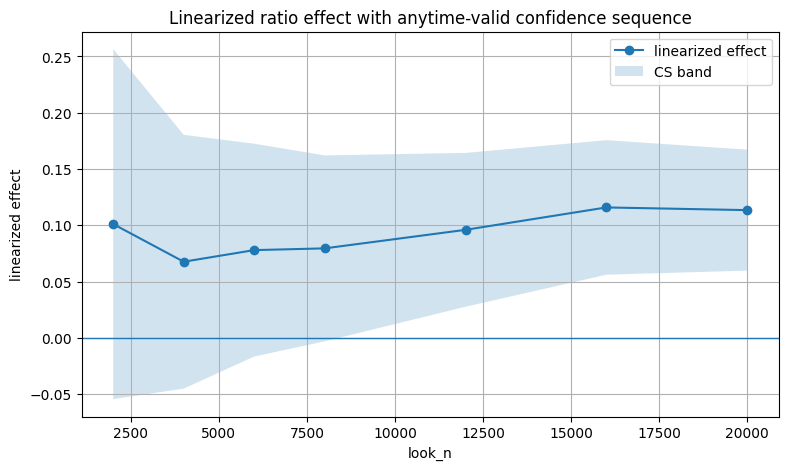

In [6]:
# Plot: effect trajectory + CS band
tab = res_cs.look_table
x = tab["look_n"].to_numpy(dtype=int)
est = tab["diff"].to_numpy(dtype=float)
cs_lo = pd.to_numeric(tab.get("cs_low"), errors="coerce").to_numpy(dtype=float)
cs_hi = pd.to_numeric(tab.get("cs_high"), errors="coerce").to_numpy(dtype=float)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, est, marker="o", label="linearized effect")
ax.fill_between(x, cs_lo, cs_hi, alpha=0.2, label="CS band")
ax.axhline(0.0, linewidth=1.0)
ax.set_title("Linearized ratio effect with anytime-valid confidence sequence")
ax.set_xlabel("look_n")
ax.set_ylabel("linearized effect")
ax.legend(loc="best")
plt.show()

## 3) Failure mode demo: denominator near-zeros
We artificially introduce near-zero denominators to show instability and why we need guardrails

baseline_bad= 1.0110742003855757
Decision with bad denominators: reject stopped= True stop_look= 12000


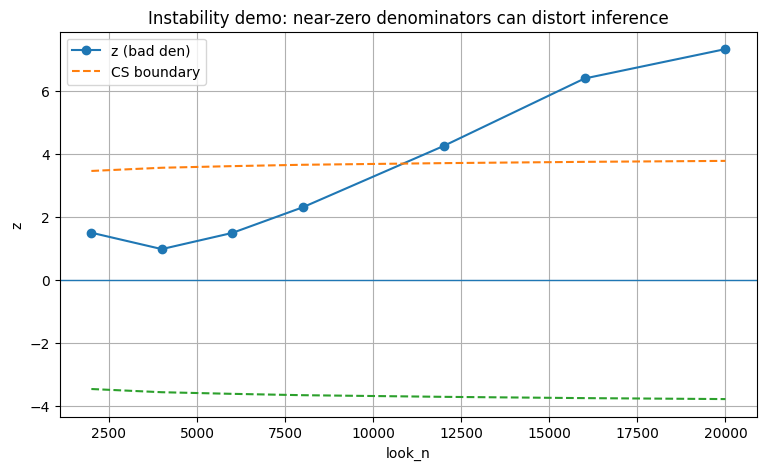

In [7]:
df_bad = df.copy()

rng = np.random.default_rng(123)
idx = rng.choice(df_bad.index.to_numpy(), size=int(0.01 * len(df_bad)), replace=False)
df_bad.loc[idx, "den"] = 1e-6

df_bad_lin, baseline_bad = linearize_ratio(
    df_bad,
    num_col="num",
    den_col="den",
    group_col="group",
    control_label="control",
    baseline_mode="first_look",
    first_look_n=looks[0],
)

lt_bad, _ = build_look_table_mean(df_bad_lin, spec, schedule, cfg_cs)
res_bad = run_confidence_sequence(lt_bad, cfg_cs)

tab = res_bad.look_table
x = tab["look_n"].to_numpy(dtype=int)
z = tab["z"].to_numpy(dtype=float)
b = pd.to_numeric(tab.get("boundary_z"), errors="coerce").to_numpy(dtype=float)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, z, marker="o", label="z (bad den)")
ax.plot(x, b, linestyle="--", label="CS boundary")
ax.plot(x, -b, linestyle="--")
ax.axhline(0.0, linewidth=1.0)
ax.set_title("Instability demo: near-zero denominators can distort inference")
ax.set_xlabel("look_n")
ax.set_ylabel("z")
ax.legend(loc="best")
plt.show()

print("baseline_bad=", baseline_bad)
print("Decision with bad denominators:", res_bad.decision, "stopped=", res_bad.stopped, "stop_look=", res_bad.stop_look)

## Interpretation
- Linearization converts ratio testing into a mean-difference problem on a constructed variable y_lin.
- Sequential monitoring then works as usual (group sequential or CS).
- Denominator pathologies (zeros / near-zeros) can create extreme variance and misleading signals.

Guardrails (v1):

- Track share of den <= 0 or den below a small threshold.
- Consider filtering / winsorization policies for extreme num/den pairs.
- Prefer a stable baseline ratio (e.g., pre-period or first look) to avoid a moving target.

## Result summary

We demonstrated sequential monitoring for a **ratio metric** via **linearization** (v1 approach: fixed baseline).

Setup:
- Schedule (K = 7): `[2000, 4000, 6000, 8000, 12000, 16000, 20000]`
- Two-sided α = 0.05
- Baseline ratio (estimated from control at the first look and then fixed): **0.9973**

Sequential decisions on the same simulated stream:
- **Group sequential (O’Brien–Fleming)**:
  - decision: **reject**
  - stop_look: **8000**
- **Anytime-valid / confidence sequence mode**:
  - decision: **reject**
  - stop_look: **12000**

Stress test (denominator pathology):
- With a “bad denominator” scenario, the run still produced:
  - decision: **reject**
  - stop_look: **12000**
- The final decision was **unchanged** compared to the regular run (`decision_changed = False`), although the denominator instability is flagged as a reliability risk and should be handled with guardrails (filtering, minimum denominator thresholds, sanity checks).

Interpretation:
- Linearization converts a ratio metric into a user-level additive metric `y_lin = num − r0·den`, enabling the same sequential machinery as for mean differences.
- Fixing the baseline `r0` (first-look control) avoids a “moving target”, which is especially important under sequential monitoring.
- In this example, O’Brien–Fleming stopped earlier (8000) than the anytime-valid mode (12000), consistent with the anytime-valid boundary being more conservative in v1.

Key takeaway:
- For ratio metrics, **sequential analysis should be done on a linearized metric with a fixed baseline**, plus explicit denominator guardrails; this yields a pragmatic and reusable interface for both group sequential and anytime-valid monitoring.